# 论文29：知识密集型任务的检索增强生成
## Patrick Lewis, Ethan Perez, Aleksandra Piktus, et al., Meta AI (2020)

### RAG：检索增强生成

将密集检索（DPR）与序列到序列生成（BART）相结合。两全其美：外部知识 + 强大的生成能力！

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## RAG 架构

```
输入查询 (x)
    ↓
检索器 (DPR) → Top-k 文档 (z)
    ↓
生成器 (BART) → P(y | x, z)
    ↓
输出 (y)
```

**两种变体：**
- **RAG-Sequence**：对整个序列在文档上边缘化
- **RAG-Token**：对每个 token 在文档上边缘化

In [2]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)

class SimpleRetriever:
    """简化的密集检索器（类似 DPR）"""
    def __init__(self, embedding_dim):
        self.embedding_dim = embedding_dim
        self.query_encoder_W = np.random.randn(embedding_dim, embedding_dim) * 0.01
    
    def encode_query(self, query_tokens):
        """将查询编码为密集向量"""
        # 简化：仅使用随机投影
        query_vec = np.mean(query_tokens, axis=0)
        encoded = np.dot(self.query_encoder_W, query_vec)
        # L2 归一化
        return encoded / (np.linalg.norm(encoded) + 1e-8)
    
    def retrieve(self, query_embedding, document_embeddings, k=5):
        """
        检索 top-k 文档
        返回：索引和概率
        """
        # 计算相似度
        similarities = np.dot(document_embeddings, query_embedding)
        
        # 获取 top-k
        top_k_indices = np.argsort(similarities)[::-1][:k]
        top_k_scores = similarities[top_k_indices]
        
        # 转换为概率
        probs = softmax(top_k_scores)
        
        return top_k_indices, probs

# 测试检索器
embedding_dim = 64
retriever = SimpleRetriever(embedding_dim)

# 虚拟数据
query_tokens = np.random.randn(10, embedding_dim)
document_embeddings = np.random.randn(20, embedding_dim)
# 归一化文档
document_embeddings = document_embeddings / (np.linalg.norm(document_embeddings, axis=1, keepdims=True) + 1e-8)

query_emb = retriever.encode_query(query_tokens)
top_indices, top_probs = retriever.retrieve(query_emb, document_embeddings, k=5)

print(f"Retrieved documents: {top_indices}")
print(f"Retrieval probabilities: {top_probs}")
print(f"Sum of probs: {np.sum(top_probs):.4f}")

Retrieved documents: [10 17  0  2  3]
Retrieval probabilities: [0.2142333  0.20422293 0.19822507 0.19417748 0.18914122]
Sum of probs: 1.0000


## 生成器（Seq2Seq）

In [3]:
class SimpleGenerator:
    """简化的 seq2seq 生成器（类似 BART）"""
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        
        # Encoder
        self.encoder_W = np.random.randn(hidden_dim, embedding_dim) * 0.01
        
        # Decoder
        self.decoder_W = np.random.randn(hidden_dim, embedding_dim) * 0.01
        self.output_W = np.random.randn(vocab_size, hidden_dim) * 0.01
    
    def generate_prob(self, query_tokens, doc_tokens, target_tokens):
        """
        计算 P(y | x, z)，其中：
        - x: 查询
        - z: 文档
        - y: 目标输出
        """
        # 编码查询 + 文档
        combined = np.concatenate([query_tokens, doc_tokens], axis=0)
        encoder_hidden = np.tanh(np.dot(self.encoder_W, np.mean(combined, axis=0)))
        
        # 解码目标
        log_prob = 0
        for target_token in target_tokens:
            decoder_hidden = np.tanh(np.dot(self.decoder_W, target_token))
            
            # 结合 encoder 和 decoder
            combined_hidden = encoder_hidden + decoder_hidden
            
            # 输出分布
            logits = np.dot(self.output_W, combined_hidden)
            probs = softmax(logits)
            
            # 假设我们知道目标 token 索引（简化）
            # 实际上，我们会计算交叉熵
            target_idx = np.argmax(target_token)  # One-hot
            log_prob += np.log(probs[target_idx] + 1e-8)
        
        return log_prob

# 测试生成器
vocab_size = 1000
generator = SimpleGenerator(vocab_size, embedding_dim, hidden_dim=128)

# 虚拟 tokens（embeddings）
query = np.random.randn(5, embedding_dim)
doc = np.random.randn(20, embedding_dim)
target = np.random.randn(8, embedding_dim)

log_prob = generator.generate_prob(query, doc, target)
print(f"\nLog P(y | x, z): {log_prob:.4f}")


Log P(y | x, z): -55.2601


## RAG-Sequence：在文档上边缘化

$$
P_{RAG-Seq}(y | x) = \sum_{z \in \text{top-k}} P(z | x) \cdot P(y | x, z)
$$

用每个文档生成完整序列，然后组合。

In [4]:
class RAGSequence:
    """RAG-Sequence 模型"""
    def __init__(self, retriever, generator):
        self.retriever = retriever
        self.generator = generator
    
    def forward(self, query_tokens, target_tokens, document_embeddings, documents_tokens, k=5):
        """
        RAG-Sequence 前向传播
        
        P(y|x) = Σ_z P(z|x) * P(y|x,z)
        """
        # 检索文档
        query_emb = self.retriever.encode_query(query_tokens)
        doc_indices, doc_probs = self.retriever.retrieve(query_emb, document_embeddings, k=k)
        
        # 在文档上边缘化
        total_prob = 0
        
        for doc_idx, p_z_given_x in zip(doc_indices, doc_probs):
            # 获取文档 tokens
            doc_tokens = documents_tokens[doc_idx]
            
            # P(y | x, z)
            log_p_y_given_xz = self.generator.generate_prob(query_tokens, doc_tokens, target_tokens)
            p_y_given_xz = np.exp(log_p_y_given_xz)
            
            # P(z|x) * P(y|x,z)
            total_prob += p_z_given_x * p_y_given_xz
        
        return np.log(total_prob + 1e-8), doc_indices, doc_probs

# 创建 RAG-Sequence 模型
rag_seq = RAGSequence(retriever, generator)

# 生成虚拟文档
num_docs = 20
documents_tokens = [np.random.randn(15, embedding_dim) for _ in range(num_docs)]

# 测试
log_prob, used_docs, used_probs = rag_seq.forward(
    query_tokens=query,
    target_tokens=target,
    document_embeddings=document_embeddings,
    documents_tokens=documents_tokens,
    k=5
)

print("\nRAG-Sequence:")
print(f"Log P(y|x): {log_prob:.4f}")
print(f"Used documents: {used_docs}")
print(f"Document weights: {used_probs}")


RAG-Sequence:
Log P(y|x): -18.4207
Used documents: [14  9  5 18 13]
Document weights: [0.21990939 0.19843539 0.19674451 0.1944869  0.19042381]


## RAG-Token：对每个 Token 边缘化

$$
P_{RAG-Token}(y | x) = \prod_{i=1}^{|y|} \sum_{z \in \text{top-k}} P(z | x) \cdot P(y_i | x, z, y_{<i})
$$

可以为不同的 token 使用不同的文档！

In [5]:
class RAGToken:
    """RAG-Token 模型（简化）"""
    def __init__(self, retriever, generator):
        self.retriever = retriever
        self.generator = generator
    
    def forward_token(self, query_tokens, target_token, document_embeddings, documents_tokens, k=5):
        """
        计算单个 token 的 P(y_i | x)
        
        P(y_i | x) = Σ_z P(z|x) * P(y_i|x,z)
        """
        # 检索文档
        query_emb = self.retriever.encode_query(query_tokens)
        doc_indices, doc_probs = self.retriever.retrieve(query_emb, document_embeddings, k=k)
        
        # 对此 token 边缘化
        token_prob = 0
        
        for doc_idx, p_z_given_x in zip(doc_indices, doc_probs):
            doc_tokens = documents_tokens[doc_idx]
            
            # P(y_i | x, z) - 简化
            log_p = self.generator.generate_prob(query_tokens, doc_tokens, [target_token])
            p_yi_given_xz = np.exp(log_p)
            
            token_prob += p_z_given_x * p_yi_given_xz
        
        return token_prob, doc_indices, doc_probs
    
    def forward(self, query_tokens, target_tokens, document_embeddings, documents_tokens, k=5):
        """
        完整序列概率
        
        P(y|x) = ∏_i P(y_i|x)
        """
        log_prob_total = 0
        
        for target_token in target_tokens:
            token_prob, _, _ = self.forward_token(
                query_tokens, target_token, document_embeddings, documents_tokens, k
            )
            log_prob_total += np.log(token_prob + 1e-8)
        
        return log_prob_total

# 创建 RAG-Token 模型
rag_token = RAGToken(retriever, generator)

# 测试
log_prob_token = rag_token.forward(
    query_tokens=query,
    target_tokens=target,
    document_embeddings=document_embeddings,
    documents_tokens=documents_tokens,
    k=5
)

print("\nRAG-Token:")
print(f"Log P(y|x): {log_prob_token:.4f}")
print("\nDifference: RAG-Token can use different docs per token!")


RAG-Token:
Log P(y|x): -55.2576

Difference: RAG-Token can use different docs per token!


## 合成 QA 示例

In [6]:
# Create more realistic example
knowledge_base = [
    "The Eiffel Tower was built in 1889 by Gustave Eiffel.",
    "Paris is the capital of France and has a population of 2.2 million.",
    "The Statue of Liberty was a gift from France to the United States.",
    "Mount Everest is 8,849 meters tall and located in the Himalayas.",
    "The Amazon River flows through South America for 6,400 kilometers.",
]

qa_pairs = [
    ("When was the Eiffel Tower built?", "1889", 0),
    ("What is the height of Mount Everest?", "8,849 meters", 3),
    ("How long is the Amazon River?", "6,400 kilometers", 4),
]

print("Knowledge Base:")
for i, doc in enumerate(knowledge_base):
    print(f"  {i}. {doc}")

print("\nQA Pairs:")
for q, a, doc_idx in qa_pairs:
    print(f"  Q: {q}")
    print(f"  A: {a}")
    print(f"  Relevant doc: #{doc_idx}")
    print()

Knowledge Base:
  0. The Eiffel Tower was built in 1889 by Gustave Eiffel.
  1. Paris is the capital of France and has a population of 2.2 million.
  2. The Statue of Liberty was a gift from France to the United States.
  3. Mount Everest is 8,849 meters tall and located in the Himalayas.
  4. The Amazon River flows through South America for 6,400 kilometers.

QA Pairs:
  Q: When was the Eiffel Tower built?
  A: 1889
  Relevant doc: #0

  Q: What is the height of Mount Everest?
  A: 8,849 meters
  Relevant doc: #3

  Q: How long is the Amazon River?
  A: 6,400 kilometers
  Relevant doc: #4



## 可视化 RAG 架构

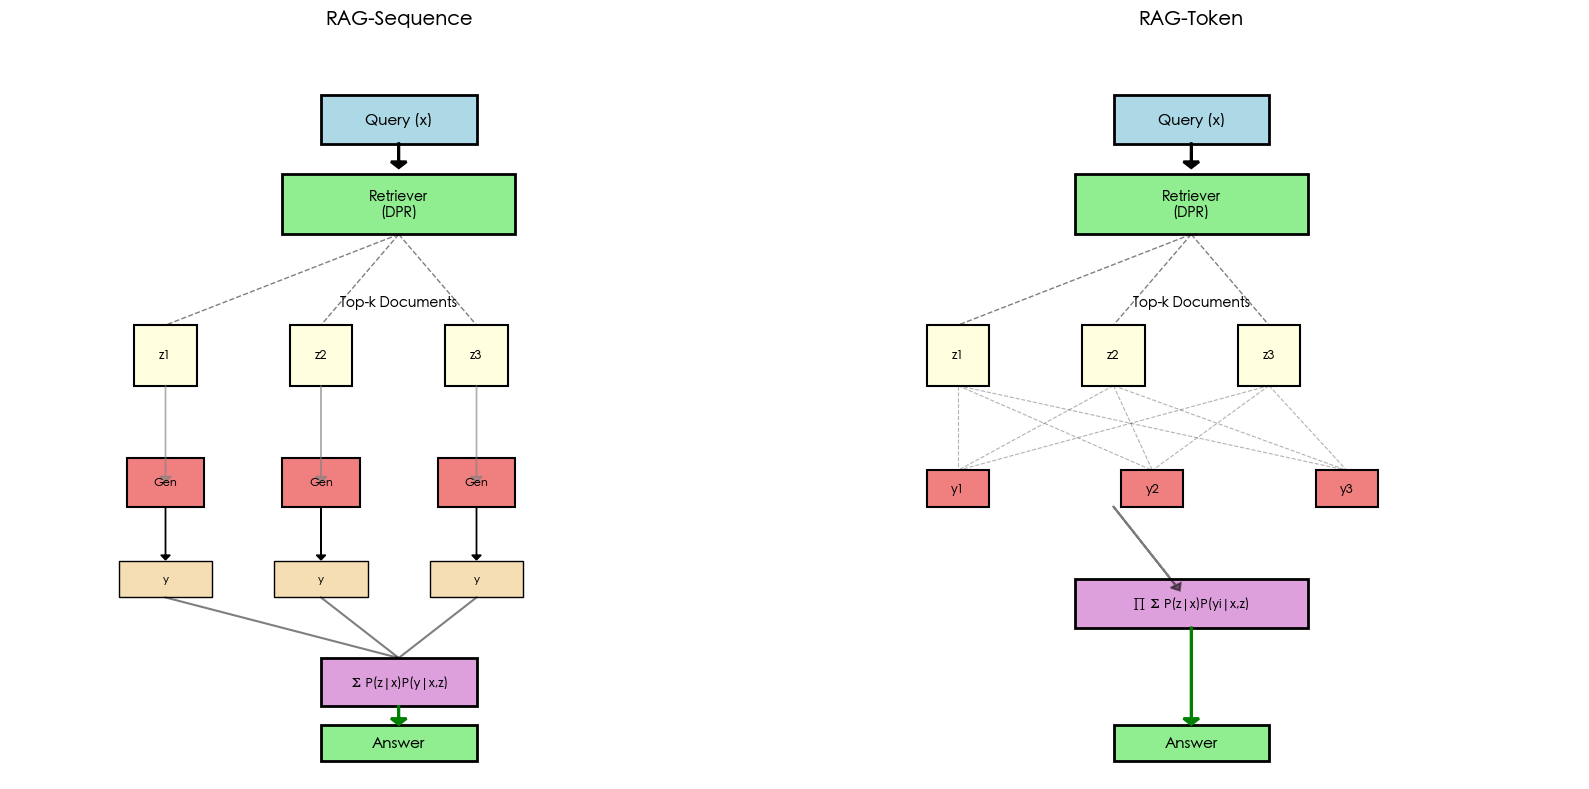

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

def draw_rag_variant(ax, title, is_token=False):
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 12)
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    
    # Query
    ax.add_patch(plt.Rectangle((4, 10.5), 2, 0.8, fill=True, 
                               color='lightblue', ec='black', linewidth=2))
    ax.text(5, 10.9, 'Query (x)', ha='center', va='center', fontsize=11, fontweight='bold')
    
    # Retriever
    ax.add_patch(plt.Rectangle((3.5, 9), 3, 1, fill=True, 
                               color='lightgreen', ec='black', linewidth=2))
    ax.text(5, 9.5, 'Retriever\n(DPR)', ha='center', va='center', fontsize=10, fontweight='bold')
    ax.arrow(5, 10.5, 0, -0.3, head_width=0.2, head_length=0.1, fc='black', ec='black', linewidth=2)
    
    # Retrieved documents
    doc_positions = [2, 4, 6, 8]
    ax.text(5, 7.8, 'Top-k Documents', ha='center', fontsize=10, fontweight='bold')
    for i, x in enumerate(doc_positions[:3]):
        ax.add_patch(plt.Rectangle((x-0.4, 6.5), 0.8, 1, fill=True, 
                                   color='lightyellow', ec='black', linewidth=1.5))
        ax.text(x, 7, f'z{i+1}', ha='center', va='center', fontsize=9)
        # Arrow from retriever
        ax.plot([5, x], [9, 7.5], 'k--', alpha=0.5, linewidth=1)
    
    if not is_token:
        # RAG-Sequence: each doc generates full sequence
        y_positions = [2, 4, 6]
        for i, (dx, dy) in enumerate(zip(doc_positions[:3], y_positions)):
            # Generator per document
            ax.add_patch(plt.Rectangle((dy-0.5, 4.5), 1, 0.8, fill=True, 
                                       color='lightcoral', ec='black', linewidth=1.5))
            ax.text(dy, 4.9, f'Gen', ha='center', va='center', fontsize=8)
            ax.arrow(dx, 6.5, dy-dx, -1.5, head_width=0.15, head_length=0.1, 
                    fc='gray', ec='gray', linewidth=1, alpha=0.6)
            
            # Output sequence
            ax.add_patch(plt.Rectangle((dy-0.6, 3), 1.2, 0.6, fill=True, 
                                       color='wheat', ec='black', linewidth=1))
            ax.text(dy, 3.3, f'y', ha='center', va='center', fontsize=8)
            ax.arrow(dy, 4.5, 0, -0.8, head_width=0.12, head_length=0.08, 
                    fc='black', ec='black', linewidth=1)
        
        # Combine
        ax.add_patch(plt.Rectangle((4, 1.2), 2, 0.8, fill=True, 
                                   color='plum', ec='black', linewidth=2))
        ax.text(5, 1.6, 'Σ P(z|x)P(y|x,z)', ha='center', va='center', fontsize=9, fontweight='bold')
        for dy in y_positions:
            ax.plot([dy, 5], [3, 2], 'k-', alpha=0.5, linewidth=1.5)
    else:
        # RAG-Token: combine docs for each token
        token_y = 4.5
        for t in range(3):
            tx = 2 + t * 2.5
            
            # Token position
            ax.add_patch(plt.Rectangle((tx-0.4, token_y), 0.8, 0.6, fill=True, 
                                       color='lightcoral', ec='black', linewidth=1.5))
            ax.text(tx, token_y+0.3, f'y{t+1}', ha='center', va='center', fontsize=9)
            
            # Arrows from all docs
            for dx in doc_positions[:3]:
                ax.plot([dx, tx], [6.5, token_y+0.6], 'k--', alpha=0.3, linewidth=0.8)
        
        # Final output
        ax.add_patch(plt.Rectangle((3.5, 2.5), 3, 0.8, fill=True, 
                                   color='plum', ec='black', linewidth=2))
        ax.text(5, 2.9, '∏ Σ P(z|x)P(yi|x,z)', ha='center', va='center', 
               fontsize=9, fontweight='bold')
        ax.arrow(4, token_y, 0.8, -1.3, head_width=0.15, head_length=0.1, 
                fc='black', ec='black', linewidth=1.5, alpha=0.5)
    
    # Final answer
    ax.add_patch(plt.Rectangle((4, 0.3), 2, 0.6, fill=True, 
                               color='lightgreen', ec='black', linewidth=2))
    ax.text(5, 0.6, 'Answer', ha='center', va='center', fontsize=11, fontweight='bold')
    ax.arrow(5, 1.2 if not is_token else 2.5, 0, 
            -0.2 if not is_token else -1.5, 
            head_width=0.2, head_length=0.1, fc='green', ec='green', linewidth=2)

draw_rag_variant(axes[0], 'RAG-Sequence', is_token=False)
draw_rag_variant(axes[1], 'RAG-Token', is_token=True)

plt.tight_layout()
plt.show()

## 比较 RAG 变体

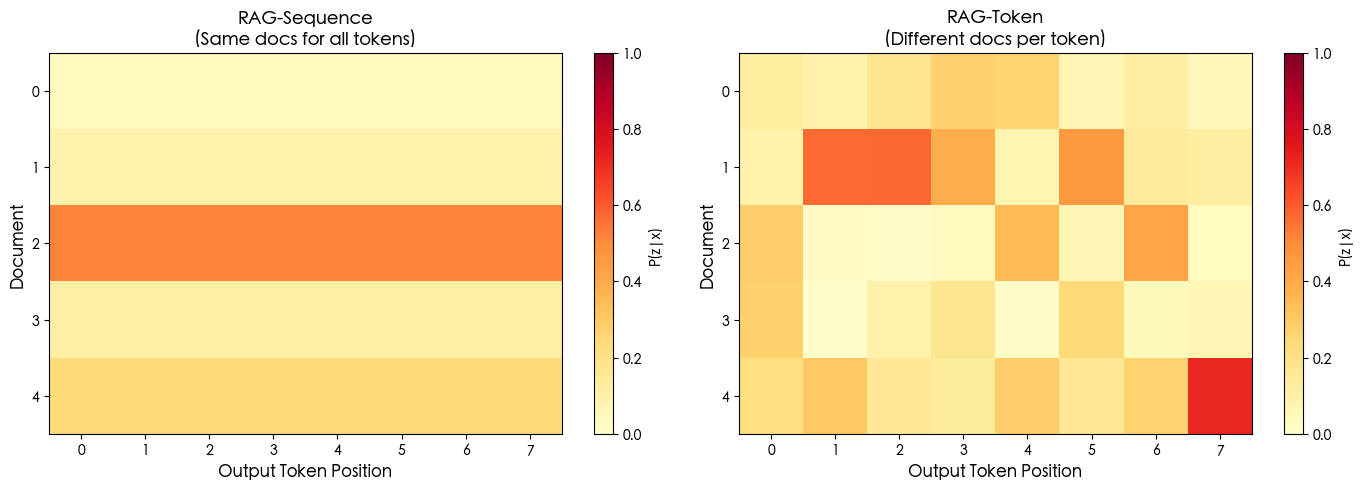


RAG-Sequence: 更一致（使用相同的知识）
RAG-Token: 更灵活（可以混合知识源）


In [8]:
# 模拟概率用于可视化
n_docs = 5
n_tokens = 8

# RAG-Sequence：所有 token 使用相同的文档权重
doc_weights_seq = softmax(np.random.randn(n_docs))
weights_seq_matrix = np.tile(doc_weights_seq, (n_tokens, 1))

# RAG-Token：每个 token 使用不同的文档权重
weights_token_matrix = np.array([softmax(np.random.randn(n_docs)) for _ in range(n_tokens)])

# 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

im1 = ax1.imshow(weights_seq_matrix.T, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
ax1.set_xlabel('Output Token Position', fontsize=12)
ax1.set_ylabel('Document', fontsize=12)
ax1.set_title('RAG-Sequence\n(Same docs for all tokens)', fontsize=13, fontweight='bold')
plt.colorbar(im1, ax=ax1, label='P(z|x)')

im2 = ax2.imshow(weights_token_matrix.T, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
ax2.set_xlabel('Output Token Position', fontsize=12)
ax2.set_ylabel('Document', fontsize=12)
ax2.set_title('RAG-Token\n(Different docs per token)', fontsize=13, fontweight='bold')
plt.colorbar(im2, ax=ax2, label='P(z|x)')

plt.tight_layout()
plt.show()

print("\nRAG-Sequence: 更一致（使用相同的知识）")
print("RAG-Token: 更灵活（可以混合知识源）")

## 关键要点

### RAG 架构：

**组件**：
1. **检索器**：密集检索（DPR 风格）
   - 查询编码器：$q_{emb} = E_Q(x)$
   - 文档编码器：$d_{emb} = E_D(z)$
   - 检索：$P(z|x) \propto \exp(q_{emb} \cdot d_{emb})$

2. **生成器**：Seq2seq 模型（BART）
   - 输入：查询 $x$ + 文档 $z$
   - 输出：$P(y | x, z)$

### RAG-Sequence：

$$
P_{RAG-Seq}(y | x) = \sum_{z \in \text{top-k}} P(z | x) \cdot P_{seq2seq}(y | x, z)
$$

**过程**：
1. 检索 top-k 文档
2. 用每个文档生成完整序列
3. 序列的加权和

**特点**：
- 每个文档生成完整答案
- 更一致（每个序列使用单一知识源）
- 更适合事实性 QA

### RAG-Token：

$$
P_{RAG-Token}(y | x) = \prod_{i=1}^{|y|} \left( \sum_{z \in \text{top-k}} P(z | x) \cdot P(y_i | x, z, y_{<i}) \right)
$$

**过程**：
1. 检索 top-k 文档（所有 token 相同）
2. 对每个 token：在文档上边缘化
3. 不同文档可以为不同 token 做出贡献

**特点**：
- 可以混合来自多个文档的信息
- 更灵活的生成
- 更适合长文本生成

### 训练：

**端到端**：
```
Loss = -log P(y* | x)
```

梯度流经：
- 生成器（BART 参数）
- 查询编码器（检索器参数）

**文档编码器**：通常冻结（预索引）

### 实现细节：

**来自论文**：
- 检索器：使用 BERT-base 的 DPR
- 生成器：BART-large（400M 参数）
- 知识库：Wikipedia（21M 段落）
- Top-k：k=5 或 k=10
- 索引：FAISS 用于快速检索

### 结果：

**Natural Questions (Open)**：
- BART（无检索）：27.0% EM
- RAG-Sequence：44.5% EM
- RAG-Token：44.1% EM

**TriviaQA**：
- BART：50.1%
- RAG：56.8%

**WebQuestions**：
- BART：27.6%
- RAG：45.2%

### RAG vs 基线：

| 模型 | 知识 | 参数化 | 性能 |
|-------|-----------|------------|-------------|
| T5-11B | 记忆化 | ✓ | 良好 |
| REALM | 检索 | 混合 | 更好 |
| **RAG** | **检索** | **✓** | **最佳** |

### 优势：

- ✅ **事实准确性**：访问外部知识
- ✅ **可扩展性**：无需重新训练即可添加知识
- ✅ **可解释性**：可以检查检索到的文档
- ✅ **效率**：比纯参数化模型更小
- ✅ **最新性**：更新索引，而非模型权重

### 局限性：

- ❌ **检索错误**：错误文档 → 错误答案
- ❌ **延迟**：检索增加开销
- ❌ **索引维护**：更新时需要重新编码
- ❌ **内存**：需要完整文档索引

### 何时使用：

**RAG-Sequence**：
- 事实性 QA
- 简短答案
- 单一来源足够时

**RAG-Token**：
- 长文本生成
- 多跳推理
- 组合多个来源

### 现代扩展：

- **RETRO** (DeepMind)：在每一层检索
- **Atlas** (Meta)：改进的训练
- **Toolformer**：通过 API 调用检索
- **WebGPT**：交互式检索
- **Self-RAG**：自反思检索

### 生产建议：

1. **混合排序**：结合检索 + 重排序
2. **缓存**：为常见查询预检索
3. **异步**：在生成时检索
4. **回退**：如果检索失败则使用参数化生成
5. **监控**：跟踪检索质量

### 应用：

- 开放域 QA（Google、Bing）
- 带知识库的聊天机器人
- 文档 QA
- 事实核查
- 研究助手
- 客户支持

### 关键洞察：

**RAG = 两全其美**
- 参数化知识（生成能力）
- 非参数化知识（外部检索）
- 端到端可微分
- 实用且有效！